In [12]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Input

In [13]:
dataset_path = "/content/drive/MyDrive/data.pkl"
print(dataset_path)

/content/drive/MyDrive/data.pkl


In [14]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
(train_imgs, train_labels), (test_imgs, test_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
test_imgs = test_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_imgs.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (1389, 224, 224, 3)
Training labels shape: (1389,)
Test images shape: (348, 224, 224, 3)
Test labels shape: (348,)


In [16]:
class_names =[
    '21-45902-3', '22-46138-1', '22-46139-1', '22-46258-1', '22-46342-1',
    '22-46536-1', '22-46590-1', '22-46887-1', '22-46983-1', '22-47542-2',
    '22-47813-2', '22-47884-2', '22-47892-2', '22-47898-2', '22-48005-2',
    '22-48021-2', '22-48023-2', '22-48091-2', '22-48133-2', '22-48205-2',
    '22-48569-3', '22-48582-3', '22-48666-3', '22-48682-3', '22-48725-3',
    '22-48833-3', '22-48841-3', '22-48915-3', '22-49037-3', '22-49068-3',
    '22-49196-3', '22-49331-3', '22-49338-3', '22-49355-3', '22-49507-3',
    '22-49538-3', '22-49575-3', '22-49643-3', '22-49783-3', '22-49791-3',
    '22-49824-3', '22-49843-3', '22-49862-3', '23-50254-1', '23-50277-1',
    '23-50346-1', '23-51127-1', '23-51308-1'
]
from sklearn.model_selection import train_test_split
train_imgs, train_labels = train_imgs[:1500], train_labels[:1500]
test_imgs, test_labels = test_imgs[:500], test_labels[:500]
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (1111, 224, 224, 3)
Training labels shape: (1111,)
Validation images shape: (278, 224, 224, 3)
Validation labels shape: (278,)


In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load ResNet50 without top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(train_imgs.shape[1], train_imgs.shape[2], 3)
)

# Freeze base layers
base_model.trainable = False

# Add your custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Data augmentation + ResNet preprocessing
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input   # <-- important for ResNet
)

datagen.fit(train_imgs)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=12),
    epochs=30,
    validation_data=(val_imgs, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning (unfreeze some or all layers)
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - accuracy: 0.0892 - loss: 3.5021 - val_accuracy: 0.0683 - val_loss: 3.3532 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0947 - loss: 3.2142 - val_accuracy: 0.0683 - val_loss: 3.3216 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.1236 - loss: 3.1639 - val_accuracy: 0.0971 - val_loss: 3.3476 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.1322 - loss: 3.1457 - val_accuracy: 0.0252 - val_loss: 3.3677 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.1342 - loss: 3.1426 - val_accuracy: 0.0504 - val_loss: 3.4362 - learning_rate: 1.0000e-04
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.1315 - loss: 3.1582 - val_accuracy: 0.0504 - val_loss: 3.4422 - learning_rate: 1.0000e-04
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - acc

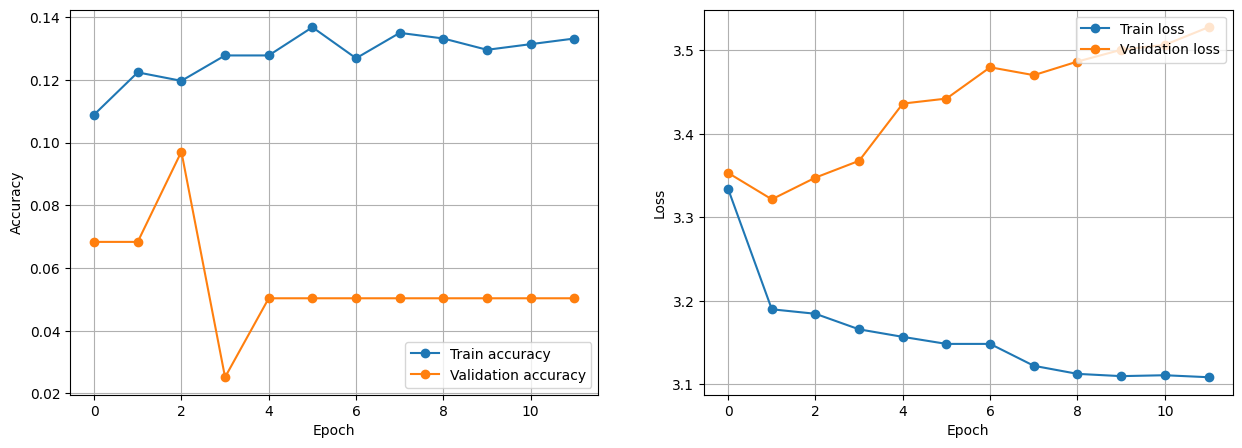

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Train loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step


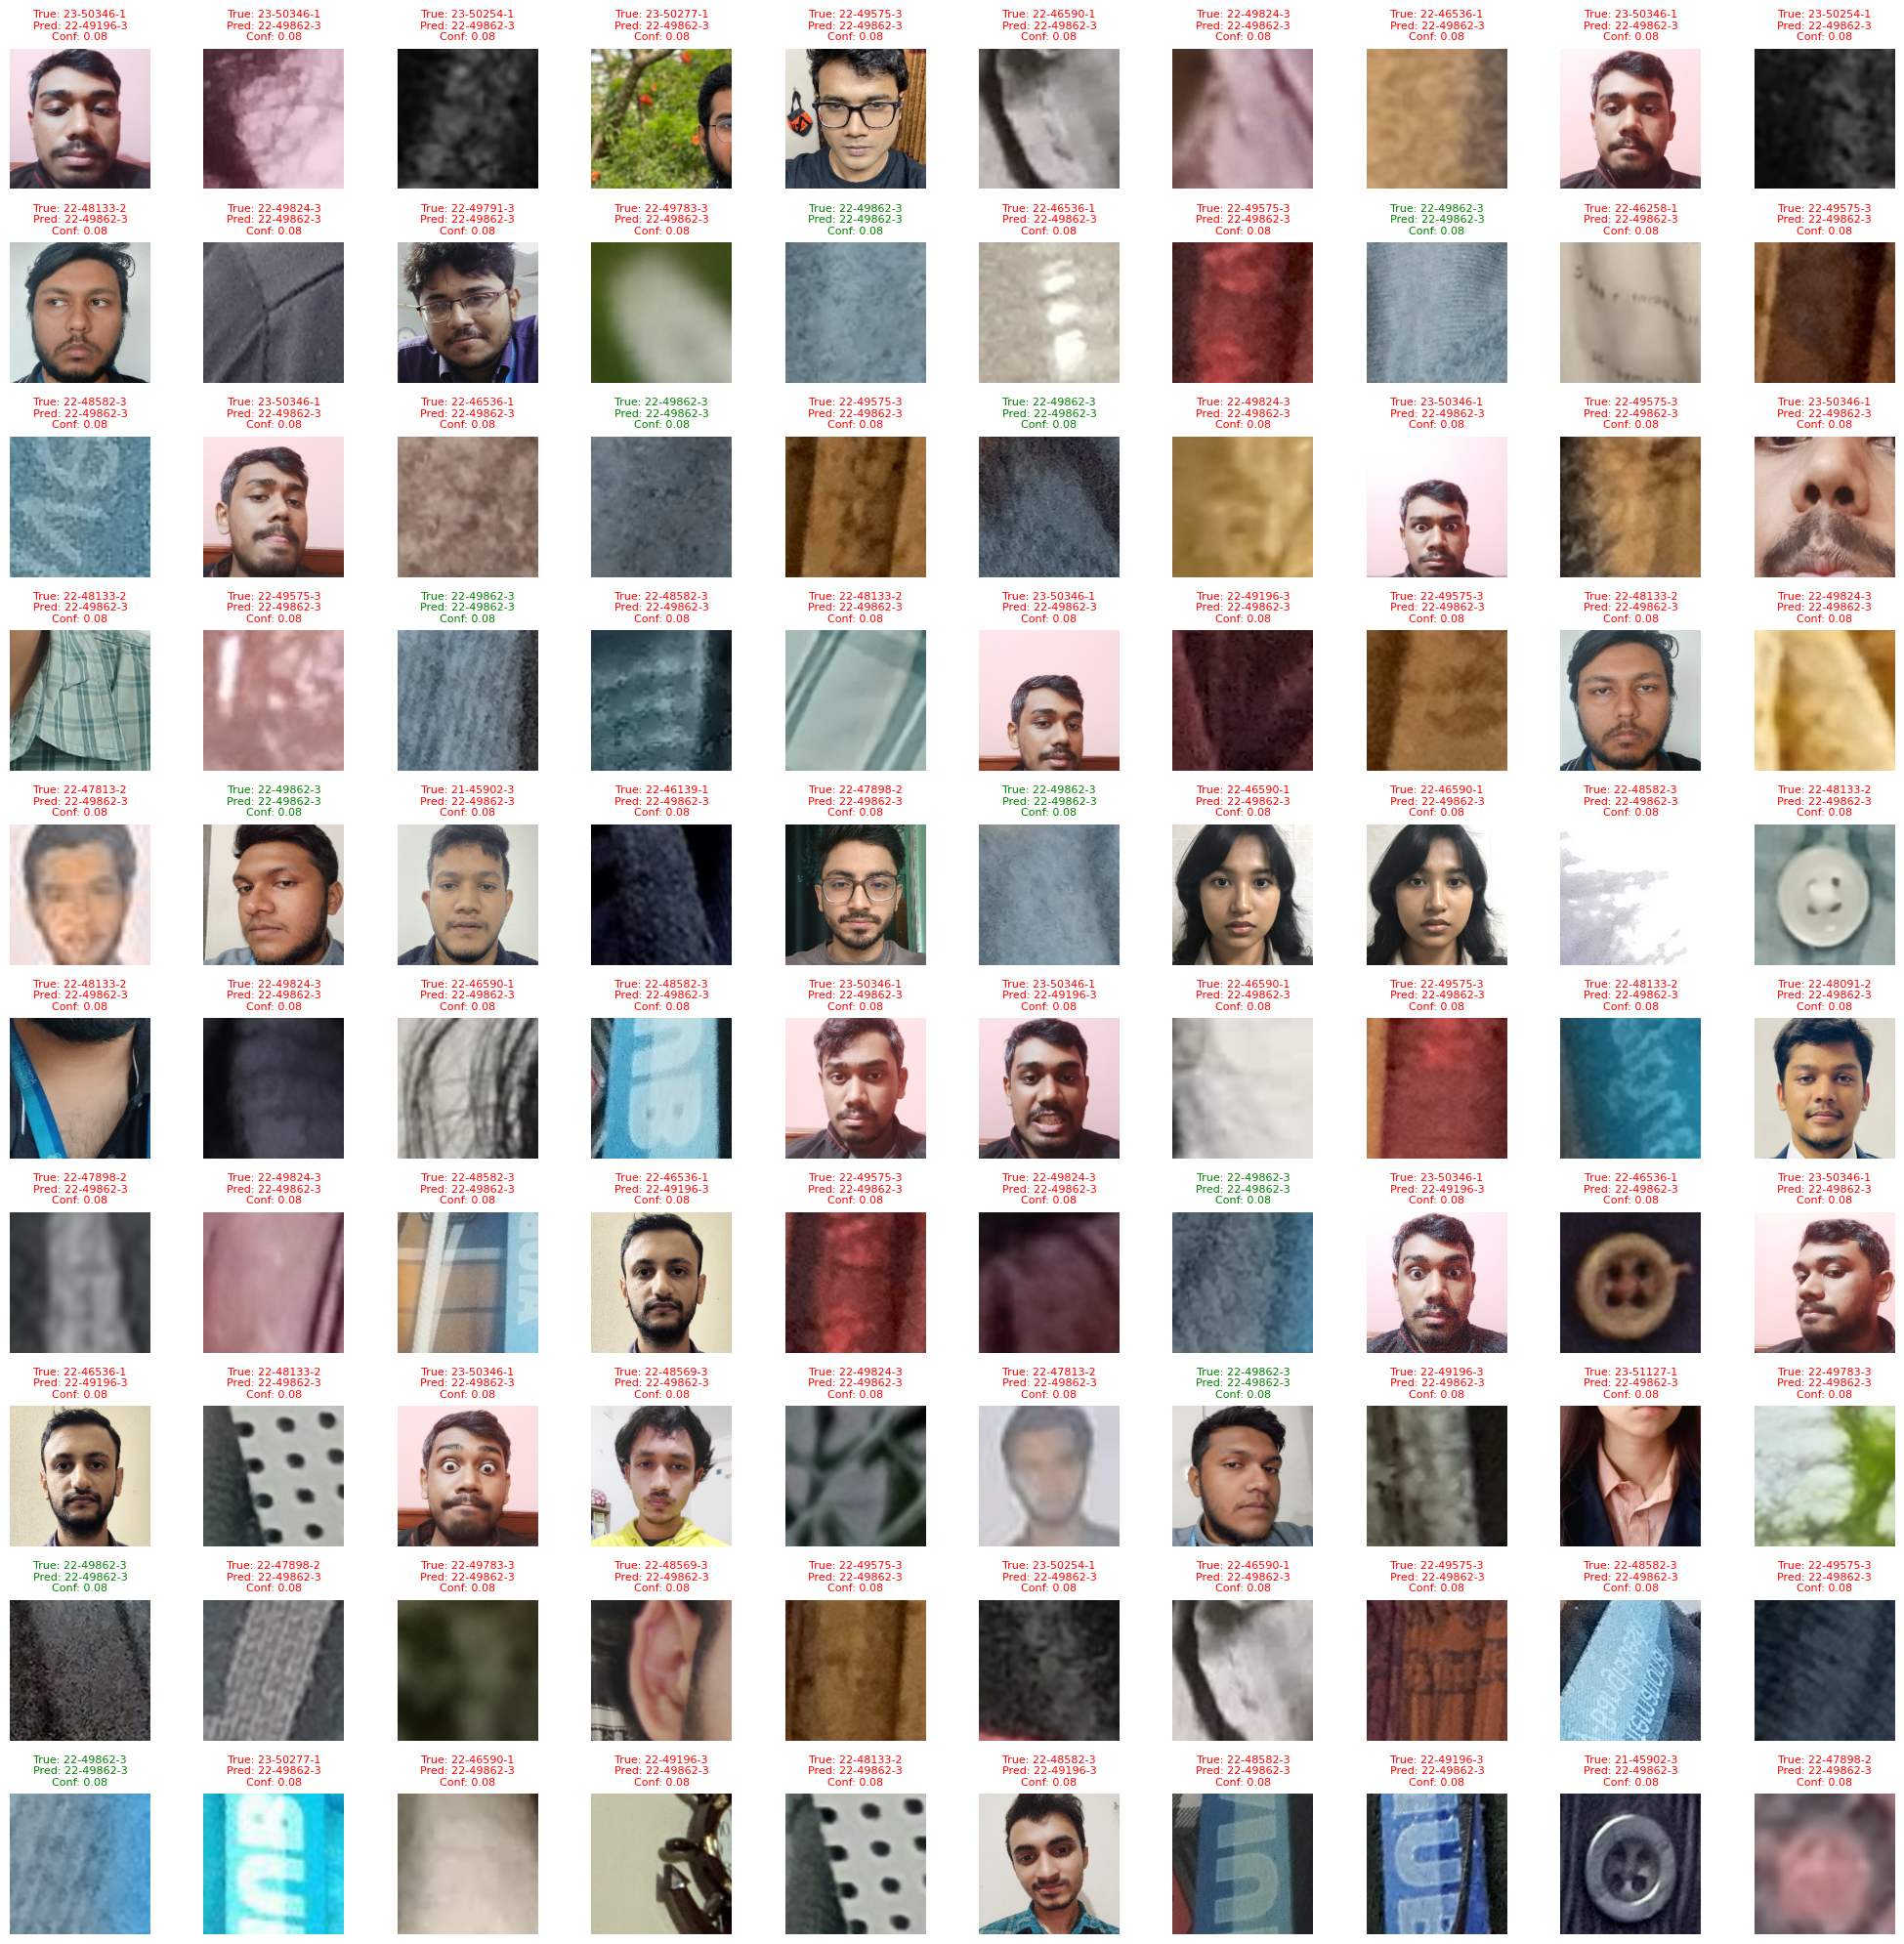

In [19]:
predictions = model.predict(val_imgs)
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.ravel()

for i in range(100):
    axes[i].imshow(val_imgs[i])
    axes[i].axis('off')

    true_label = class_names[val_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidence_levels[i]

    color = "green" if predicted_classes[i] == val_labels[i] else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()

In [20]:
model.save('face_recognition_model.keras')

In [21]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)